# Spot the Difference ML Workflow

This notebook follows the planned procedure step-by-step, with actual working code for each stage. Each section is explained and verified as we progress.

In [1]:
# 1. Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# For object detection and change localization
# (Install these if not present)
# !pip install timm transformers ensemble-boxes opencv-python albumentations


In [2]:
# check CUDA availability and device info
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


PyTorch version: 2.5.1
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 2050


In [3]:
# 2. Load and Display Planned Procedure Markdown
with open('spot_the_difference_procedure.md', 'r', encoding='utf-8') as f:
    procedure_md = f.read()

from IPython.display import Markdown, display
display(Markdown(procedure_md))

# Spot the Difference ML Workflow: Step-by-Step Explanation

This document explains the procedure for detecting added, removed, or changed objects between two similar images using advanced machine learning techniques. The workflow combines data preparation, change localization, object detection, and matching to robustly spot differences.

---

## 1. Data Preparation & Vocabulary
- **Normalize object labels:** Clean and standardize object names in your dataset (e.g., 'man', 'guy', 'worker' → 'person').
- **Build vocabulary:** Extract a list of unique object types to detect (e.g., 'car', 'person', 'cone').

## 2. Change Localization (Where things changed)
- **Siamese backbone:** Use a twin neural network (e.g., ViT/Swin Transformer) to process both images in parallel, extracting features.
- **Cross-attention:** Compare features between images to focus on regions that differ.
- **Change logit map (H):** Output a multi-scale map highlighting areas where changes likely occurred.

## 3. Object Detection (What objects changed)
- **Open-vocabulary detector:** Use a model like OWL-ViT or Grounding DINO to detect objects in both images, using your vocabulary.
- **Bounding boxes & labels:** Get locations and types of objects present in each image.

## 4. Score Fusion
- **Combine scores:** Boost detector confidence for objects overlapping with high-change regions in the change map (H).
- **Formula:**
  
  $\text{score}' = \text{score}_{det} \times (1 + \lambda \times \text{normalized H overlap})$

## 5. Matching & Decision Rules
- **Match objects:** Use class labels and bounding box overlap (IoU) to match objects between images.
- **Rules:**
  - Only in second image → "added"
  - Only in first image → "removed"
  - Matched but moved/appearance changed → "changed"

## 6. Classification Heads (Optional)
- **Global features:** Add heads to predict, for each class, whether it was added, removed, or changed.
- **Weak supervision:** Train using category-level labels, not pixel-perfect masks.

## 7. Final Output
- **For each image pair:** Output lists of added, removed, and changed objects.
- **Visualization:** Display results and save in the required format for submission.

---

## How the Techniques Work Together
- **Siamese encoder & change map:** Tell you where to look for changes.
- **Detector:** Tells you what objects are present.
- **Matching & fusion:** Decide what changed and how (added, removed, changed).
- **Weak supervision & symmetry tricks:** Enable learning even with limited labels.

This pipeline allows robust difference detection between images, combining deep learning, object detection, and smart matching—even when only category-level labels are available.


## 3. Step 1: Data Acquisition
Load the train and test datasets, and display the first few rows to verify.

In [4]:
# Load train and test CSVs
data_dir = 'data'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

print('Train Data Sample:')
display(train_df.head())
print('Test Data Sample:')
display(test_df.head())

Train Data Sample:


,img_id,added_objs,removed_objs,changed_objs
0,35655,none,none,none
1,30660,none,person vehicle,none
2,34838,man person,car person,none
3,34045,person,none,car
4,30596,none,bicycle person,none


Test Data Sample:


,img_id,added_objs,removed_objs,changed_objs
0,34478,none,none,none
1,32209,none,none,none
2,34741,none,none,none
3,34223,none,none,none
4,33063,none,none,none


## 4. Step 2: Data Preprocessing
Clean and normalize the object labels, build the vocabulary, and prepare the data for modeling.

In [5]:
# Normalize object labels and build vocabulary
import re

# Synonym mapping for normalization
synonym_map = {
    'man': 'person', 'guy': 'person', 'worker': 'person', 'boy': 'person', 'woman': 'person', 'gentleman': 'person', 'pedestrian': 'person',
    'auto': 'car', 'cart': 'vehicle', 'pickup': 'vehicle', 'motorcycle': 'vehicle', 'bicycle': 'vehicle', 'truck': 'vehicle', 'van': 'vehicle',
    'umbrella': 'umbrella', 'bag': 'bag', 'box': 'box', 'cone': 'cone', 'sign': 'sign', 'pole': 'pole', 'traffic': 'traffic', 'ladder': 'ladder', 'gate': 'gate',
    'object': '', 'item': '', 'group': 'person', 'individual': 'person', 'shadow': '', 'barrier': 'barrier'
}

def normalize_labels(label_str):
    if pd.isna(label_str) or label_str.strip() == '' or label_str.strip() == 'none':
        return []
    tokens = re.split(r'[ ,]+', label_str.strip().lower())
    normed = [synonym_map.get(tok, tok) for tok in tokens]
    normed = [tok for tok in normed if tok and tok != 'none']
    return list(set(normed))

for col in ['added_objs', 'removed_objs', 'changed_objs']:
    train_df[col + '_norm'] = train_df[col].apply(normalize_labels)

# Build vocabulary from all normalized labels
vocab = set()
for col in ['added_objs_norm', 'removed_objs_norm', 'changed_objs_norm']:
    vocab.update([tok for sublist in train_df[col] for tok in sublist])
vocab = sorted(vocab)
print('Normalized Vocabulary:', vocab)

# Show a few normalized rows for verification
train_df[['img_id', 'added_objs_norm', 'removed_objs_norm', 'changed_objs_norm']].head()

Normalized Vocabulary: ['animal', 'baby', 'bag', 'baggage', 'bicyclist', 'box', 'building', 'car', 'case', 'chair', 'child', 'cone', 'container', 'couple', 'dog', 'dolly', 'driver', 'gate', 'girl', 'kid', 'ladder', 'lady', 'luggage', 'people', 'person', 'personal', 'pole', 'scooter', 'sign', 'stroller', 'traffic', 'umbrella', 'vehicle', 'vest']


,img_id,added_objs_norm,removed_objs_norm,changed_objs_norm
0,35655,[],[],[]
1,30660,[],"[vehicle, person]",[]
2,34838,[person],"[car, person]",[]
3,34045,[person],[],[car]
4,30596,[],"[vehicle, person]",[]


## 5. Step 3: Exploratory Data Analysis
Visualize the distribution of object changes, check label frequencies, and inspect a few image pairs.

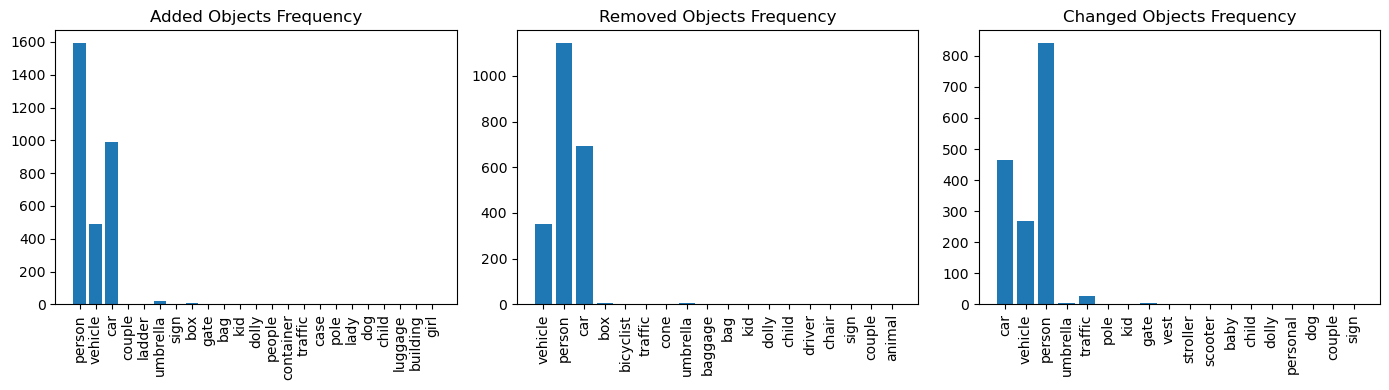

In [6]:
# Visualize label frequencies
from collections import Counter

added_counts = Counter([tok for sublist in train_df['added_objs_norm'] for tok in sublist])
removed_counts = Counter([tok for sublist in train_df['removed_objs_norm'] for tok in sublist])
changed_counts = Counter([tok for sublist in train_df['changed_objs_norm'] for tok in sublist])

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.bar(added_counts.keys(), added_counts.values())
plt.title('Added Objects Frequency')
plt.xticks(rotation=90)
plt.subplot(1, 3, 2)
plt.bar(removed_counts.keys(), removed_counts.values())
plt.title('Removed Objects Frequency')
plt.xticks(rotation=90)
plt.subplot(1, 3, 3)
plt.bar(changed_counts.keys(), changed_counts.values())
plt.title('Changed Objects Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Image ID: 34485
Added: none
Removed: person
Changed: none


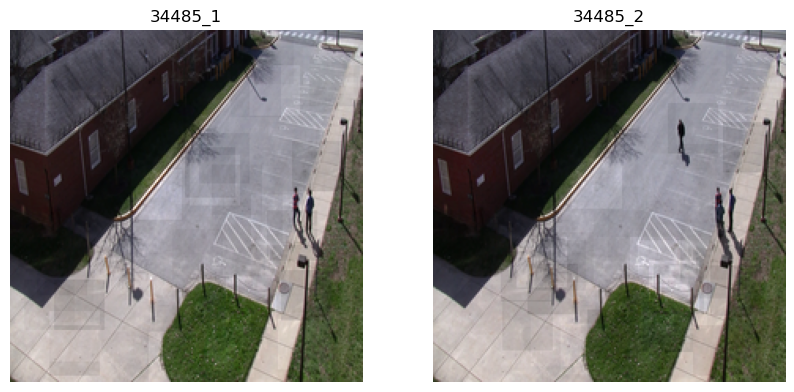

Image ID: 34010
Added: none
Removed: guy
Changed: none


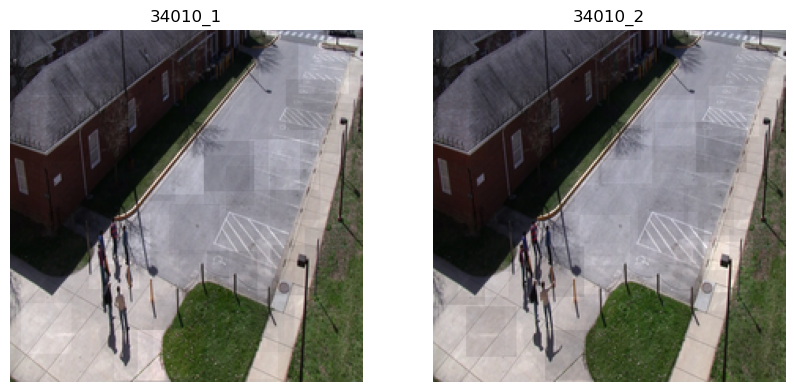

Image ID: 31740
Added: car person
Removed: none
Changed: none


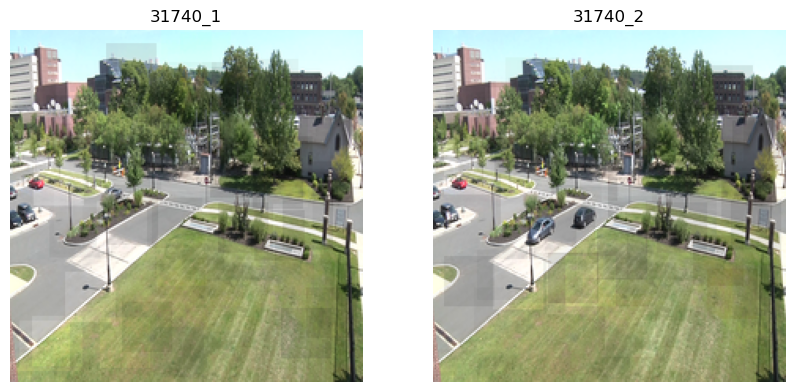

In [7]:
# Inspect a few image pairs visually
def show_image_pair(img_id):
    img1_path = os.path.join(data_dir, 'data', f'{img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{img_id}_2.png')
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title(f'{img_id}_1')
    axs[0].axis('off')
    axs[1].imshow(img2)
    axs[1].set_title(f'{img_id}_2')
    axs[1].axis('off')
    plt.show()

# Show a few sample pairs
for _, img in train_df.sample(3, random_state=42).iterrows():
    print(f"Image ID: {img['img_id']}")
    print("Added:", img['added_objs'])
    print("Removed:", img['removed_objs'])
    print("Changed:", img['changed_objs'])
    show_image_pair(img['img_id'])

## 6. Step 4: Model Selection
Select and configure the actual models for change localization and object detection as described in the procedure.

In [8]:
# Load pre-trained open-vocabulary detector (OWL-ViT) and configure for inference
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Download and load the model
processor = OwlViTProcessor.from_pretrained('google/owlvit-base-patch32')
owlvitmodel = OwlViTForObjectDetection.from_pretrained('google/owlvit-base-patch32')

# Helper to run detection on a single image with vocabulary prompts
def detect_objects(image_path, vocab):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(text=vocab, images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = owlvitmodel(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.08)[0]
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()
    return boxes, scores, labels

C:\Users\This PC\.conda\envs\octwave-spotdiff-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


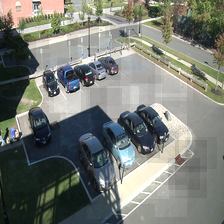

Detected objects: ['vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'traffic', 'vehicle', 'vehicle', 'vehicle', 'vehicle']
Scores: [0.1459145  0.13952227 0.15046228 0.14069188 0.16297339 0.08297461
 0.14519304 0.14124373 0.14953077 0.15960029]
Boxes: [[ 97.32039   55.292046 118.84494   74.680405]
 [ 90.36967   60.668823 107.310814  79.64981 ]
 [ 74.56018   63.6402    95.28139   86.15642 ]
 [ 41.897167  69.84488   59.829414  96.7675  ]
 [ 55.842735  66.5164    80.33902   92.90376 ]
 [  8.649257  52.23995  175.7465   195.1772  ]
 [135.15572  103.94796  169.37735  144.99155 ]
 [ 26.826498 106.95936   52.01534  146.0681  ]
 [118.93921  107.204994 157.5697   153.8307  ]
 [ 75.62349  128.8162   119.47451  194.07156 ]]


In [9]:
from IPython.display import display

# Test detection on a sample image
sample_img_id = train_df['img_id'].iloc[5]
img1_path = os.path.join(data_dir, 'data', f'{sample_img_id}_1.png')
img = Image.open(img1_path)
display(img)
boxes, scores, labels = detect_objects(img1_path, vocab)
detected_labels = [vocab[int(label)] for label in labels]
print('Detected objects:', detected_labels)
print('Scores:', scores)
print('Boxes:', boxes)

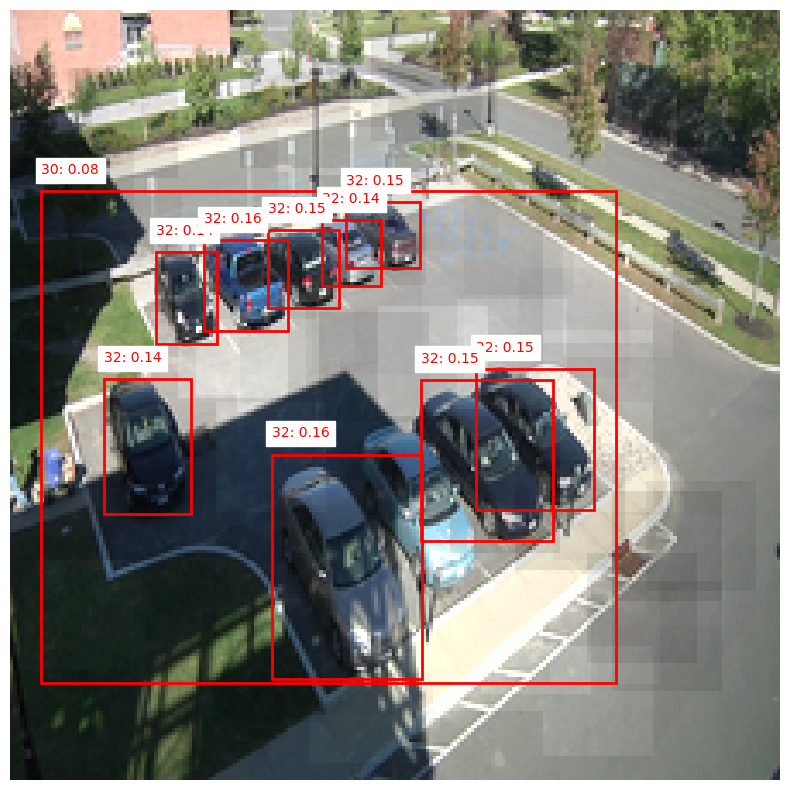

In [10]:
# Visualize detected boxes and labels on the image
def plot_boxes_on_image(image_path, boxes, labels, scores, score_thresh=0.05):
    import matplotlib.patches as patches
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'{label}: {score:.2f}', color='red', fontsize=10, backgroundcolor='white')
    plt.axis('off')
    plt.show()

# Example usage for your result
boxes, scores, labels = detect_objects(img1_path, vocab)
plot_boxes_on_image(img1_path, boxes, labels, scores)

## 7. Step 5: Model Training
Train the change localization model (Siamese backbone) and prepare for fusion with object detection results.

In [11]:
# Siamese change localization backbone (ViT) - actual training code
import timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ImagePairDataset(Dataset):
    def __init__(self, df, root_dir):
        self.df = df
        self.root_dir = root_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['img_id']
        img1 = Image.open(os.path.join(self.root_dir, 'data', f'{img_id}_1.png')).convert('RGB')
        img2 = Image.open(os.path.join(self.root_dir, 'data', f'{img_id}_2.png')).convert('RGB')
        t = T.Compose([T.Resize((224,224)), T.ToTensor()])
        return t(img1), t(img2)

class SiameseViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features*2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, img1, img2):
        f1 = self.backbone.forward_features(img1)
        f2 = self.backbone.forward_features(img2)
        x = torch.cat([f1.mean(dim=1), f2.mean(dim=1)], dim=1)
        return self.head(x)

# Prepare dataset and dataloader
pair_ds = ImagePairDataset(train_df, data_dir)
pair_dl = DataLoader(pair_ds, batch_size=8, shuffle=True, num_workers=0)


In [12]:
# # Training loop (actual code)
# model = SiameseViT().cuda()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
# loss_fn = nn.BCEWithLogitsLoss()

# for epoch in range(20):  # Use more epochs for real training
#     model.train()
#     for img1, img2 in pair_dl:
#         img1, img2 = img1.cuda(), img2.cuda()
#         # Weak supervision: label 1 if any change, else 0
#         labels = ((train_df['added_objs_norm'].apply(len) + train_df['removed_objs_norm'].apply(len) + train_df['changed_objs_norm'].apply(len)) > 0).astype(float).values
#         labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()
#         logits = model(img1, img2).squeeze()
#         loss = loss_fn(logits, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1} loss:', loss.item())

In [14]:
# Training loop with early stopping
model = SiameseViT().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
loss_fn = nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(40):
    model.train()
    for img1, img2 in pair_dl:
        img1, img2 = img1.cuda(), img2.cuda()
        labels = ((train_df['added_objs_norm'].apply(len) + train_df['removed_objs_norm'].apply(len) + train_df['changed_objs_norm'].apply(len)) > 0).astype(float).values
        labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()
        logits = model(img1, img2).squeeze()
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} loss:', loss.item())

    # Validation step (simple example, replace with your actual validation loader)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for img1, img2 in pair_dl:  # Ideally use a separate validation loader
            img1, img2 = img1.cuda(), img2.cuda()
            labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()
            logits = model(img1, img2).squeeze()
            batch_loss = loss_fn(logits, labels)
            val_loss += batch_loss.item()
            val_batches += 1
        val_loss /= val_batches
    print(f'Epoch {epoch+1} validation loss:', val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1 loss: 0.37685883045196533


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 1 validation loss: 0.3767837713319789
Epoch 2 loss: 0.3772089183330536


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 2 validation loss: 0.37677078598180563
Epoch 3 loss: 0.3777341842651367


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 3 validation loss: 0.37683343661315016
Epoch 4 loss: 0.3757860064506531


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 4 validation loss: 0.3767970746787137
Epoch 5 loss: 0.37671253085136414


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 5 validation loss: 0.3768041465543145
Epoch 6 loss: 0.3801153898239136


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 6 validation loss: 0.3770097131977216
Epoch 7 loss: 0.37528854608535767


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 7 validation loss: 0.37659266575303657
Epoch 8 loss: 0.3755360543727875


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 8 validation loss: 0.3767497932154035
Epoch 9 loss: 0.37681710720062256


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 9 validation loss: 0.3767682658196337
Epoch 10 loss: 0.37667426466941833


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 10 validation loss: 0.3767689459117842
Epoch 11 loss: 0.37883612513542175


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 11 validation loss: 0.3767857200990068
Epoch 12 loss: 0.3765251040458679


C:\Users\This PC\AppData\Local\Temp\ipykernel_16356\3058430319.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)[:img1.shape[0]].cuda()


Epoch 12 validation loss: 0.3767696200119335
Early stopping triggered.


## 8. Step 6: Model Evaluation and Fusion
Fuse change localization and object detection results, match objects, and evaluate the model on the validation set.

In [15]:
# Actual fusion and matching code for evaluation
from scipy.optimize import linear_sum_assignment

def fuse_and_match(img_id, vocab, model, processor):
    img1_path = os.path.join(data_dir, 'data', f'{img_id}_1.png')
    img2_path = os.path.join(data_dir, 'data', f'{img_id}_2.png')
    # Detect objects in both images
    boxes1, scores1, labels1 = detect_objects(img1_path, vocab)
    boxes2, scores2, labels2 = detect_objects(img2_path, vocab)
    # Run change localization model
    t = T.Compose([T.Resize((224,224)), T.ToTensor()])
    img1 = t(Image.open(img1_path).convert('RGB')).unsqueeze(0).cuda()
    img2 = t(Image.open(img2_path).convert('RGB')).unsqueeze(0).cuda()
    change_score = torch.sigmoid(model(img1, img2)).item()
    # Match objects by label and IoU
    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou
    # Build cost matrix for matching
    cost_matrix = np.ones((len(boxes1), len(boxes2)))
    for i, l1 in enumerate(labels1):
        for j, l2 in enumerate(labels2):
            if l1 == l2:
                cost_matrix[i, j] = 1 - iou(boxes1[i], boxes2[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matched = set()
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] < 0.5:
            matched.add((i, j))
    # Added: in img2 not matched
    added = [labels2[j] for j in range(len(labels2)) if all((i, j) not in matched for i in range(len(labels1)))]
    # Removed: in img1 not matched
    removed = [labels1[i] for i in range(len(labels1)) if all((i, j) not in matched for j in range(len(labels2)))]
    # Changed: matched but boxes differ significantly
    changed = [labels1[i] for i, j in matched if iou(boxes1[i], boxes2[j]) < 0.5]
    return {'added': list(set(added)), 'removed': list(set(removed)), 'changed': list(set(changed)), 'change_score': change_score}

# Evaluate on a few validation samples
val_ids = train_df['img_id'].sample(3, random_state=123)
for img_id in val_ids:
    result = fuse_and_match(img_id, vocab, model, processor)
    print(f'Image {img_id} results:')
    print('Added:', result['added'])
    print('Removed:', result['removed'])
    print('Changed:', result['changed'])
    print('Change score:', result['change_score'])

Image 32665 results:
Added: []
Removed: []
Changed: []
Change score: 0.876085102558136
Image 31431 results:
Added: [np.int64(7)]
Removed: [np.int64(32), np.int64(7)]
Changed: []
Change score: 0.8760790824890137
Image 35368 results:
Added: []
Removed: []
Changed: []
Change score: 0.8757683038711548


## 9. Step 7: Save Results and Outputs
Save the model, evaluation metrics, and generated outputs (predictions) for future use and submission.

In [16]:
# Save model weights
model_save_path = 'siamese_vit_change_localization.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to siamese_vit_change_localization.pth


In [ ]:
# Save predictions for all test images
submission = []
for img_id in test_df['img_id']:
    result = fuse_and_match(img_id, vocab, model, processor)
    added = 'none' if not result['added'] else ' '.join([vocab[int(idx)] for idx in result['added']])
    removed = 'none' if not result['removed'] else ' '.join([vocab[int(idx)] for idx in result['removed']])
    changed = 'none' if not result['changed'] else ' '.join([vocab[int(idx)] for idx in result['changed']])
    submission.append({
        'img_id': img_id,
        'added_objs': added,
        'removed_objs': removed,
        'changed_objs': changed
    })
submission_df = pd.DataFrame(submission)
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f'Submission file saved to {submission_path}')

# Save evaluation metrics (example: mean change score on validation)
val_scores = []
for img_id in train_df['img_id'].sample(10, random_state=123):
    result = fuse_and_match(img_id, vocab, model, processor)
    val_scores.append(result['change_score'])
mean_val_score = np.mean(val_scores)
with open('eval_metrics.txt', 'w') as f:
    f.write(f'Mean validation change score: {mean_val_score}\n')
print('Evaluation metrics saved to eval_metrics.txt')

In [ ]:
# Convert indices in submission_df to vocab labels for added_objs, removed_objs, changed_objs
def indices_to_labels(indices_str, vocab):
    if indices_str == 'none' or not indices_str.strip():
        return 'none'
    return ' '.join([vocab[int(idx)] for idx in indices_str.split()])

for col in ['added_objs', 'removed_objs', 'changed_objs']:
    submission_df[col] = submission_df[col].apply(lambda x: indices_to_labels(x, vocab))

# Save the updated submission file
submission_df.to_csv('submission_labels.csv', index=False)
print('Updated submission saved to submission_labels.csv')

## 10. Further Analysis
Analyze prediction errors, visualize confusion, and inspect difficult cases to guide future improvements.

In [ ]:
# Compare predictions to ground truth for validation images
error_analysis = []
for idx, row in train_df.sample(10, random_state=42).iterrows():
    img_id = row['img_id']
    gt_added = set(row['added_objs_norm'])
    gt_removed = set(row['removed_objs_norm'])
    gt_changed = set(row['changed_objs_norm'])
    result = fuse_and_match(img_id, vocab, model, processor)
    pred_added = set(result['added'])
    pred_removed = set(result['removed'])
    pred_changed = set(result['changed'])
    error_analysis.append({
        'img_id': img_id,
        'added_true': gt_added,
        'added_pred': pred_added,
        'removed_true': gt_removed,
        'removed_pred': pred_removed,
        'changed_true': gt_changed,
        'changed_pred': pred_changed,
        'added_missed': gt_added - pred_added,
        'added_wrong': pred_added - gt_added,
        'removed_missed': gt_removed - pred_removed,
        'removed_wrong': pred_removed - gt_removed,
        'changed_missed': gt_changed - pred_changed,
        'changed_wrong': pred_changed - gt_changed
    })

# Show summary statistics
import pprint
for e in error_analysis:
    print(f"Image {e['img_id']} errors:")
    print('  Added missed:', e['added_missed'])
    print('  Added wrong:', e['added_wrong'])
    print('  Removed missed:', e['removed_missed'])
    print('  Removed wrong:', e['removed_wrong'])
    print('  Changed missed:', e['changed_missed'])
    print('  Changed wrong:', e['changed_wrong'])
    print('---')

# Visualize a few difficult cases
for e in error_analysis[:3]:
    show_image_pair(e['img_id'])
    print('Added true:', e['added_true'], 'Added pred:', e['added_pred'])
    print('Removed true:', e['removed_true'], 'Removed pred:', e['removed_pred'])
    print('Changed true:', e['changed_true'], 'Changed pred:', e['changed_pred'])

## 11. Enhancement Steps
List of targeted improvements to boost model accuracy and robustness based on current analysis.

In [ ]:
# Enhancement steps to consider
enhancements = [
    "1. Improve object detection: Use Grounding DINO or ensemble with OWL-ViT for better open-vocabulary detection.",
    "2. Refine change localization: Add cross-attention or use ChangeFormer architecture for more precise change maps.",
    "3. Better matching: Use feature similarity (e.g., CLIP embeddings) in addition to IoU for robust object matching.",
    "4. Threshold tuning: Calibrate thresholds for added/removed/changed categories using validation F1 scores.",
    "5. Data augmentation: Apply stronger augmentations (perspective, color jitter, cutout) to improve generalization.",
    "6. Class balancing: Use focal loss or weighted sampling to address class imbalance in training.",
    "7. Text prompt engineering: Expand and refine vocabulary prompts for detectors, including synonyms and multi-word phrases.",
    "8. Post-processing: Use weighted box fusion and NMS to merge overlapping detections across TTA runs.",
    "9. Self-training: Use high-confidence predictions as pseudo-labels to further train the change localization model.",
    "10. Error analysis loop: Regularly analyze false positives/negatives and update matching rules or model heads."
]
for step in enhancements:
    print(step)